In [232]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [233]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install quandl
import quandl
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats
!pip install ffn
import ffn
!pip install --upgrade pip

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [234]:
# Natural Gas continuous contract
print('\033[4mBrent Crude Futures, Continuous Contract\033[0m')
BC = quandl.get("CHRIS/ICE_B1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
BC = BC.loc['2010-01-01':,]
BC.sort_index(ascending=True, inplace=True)
BC.tail()

Brent Crude Futures, Continuous Contract


,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
Date,,,,,,,,,,,
2020-12-22,50.65,50.86,49.56,50.08,-0.83,50.21,192602.0,211345.0,NaN,NaN,1498.0
2020-12-23,49.70,51.59,49.20,51.20,1.12,50.56,179707.0,178792.0,NaN,NaN,2924.0
2020-12-24,51.11,51.77,50.62,51.29,0.09,51.19,94528.0,135884.0,1800.0,NaN,360.0
2020-12-28,51.25,52.02,50.53,50.86,NaN,51.28,81059.0,128364.0,NaN,NaN,NaN
2020-12-29,51.02,51.63,50.86,51.09,0.23,51.30,87379.0,105934.0,3828.0,NaN,125.0


In [235]:
print(BC.columns); print(BC.shape)

Index(['Open', 'High', 'Low', 'Settle', 'Change', 'Wave', 'Volume', 'Prev. Day Open Interest', 'EFP Volume', 'EFS Volume', 'Block Volume'], dtype='object')
(2838, 11)


Open                         24
High                         24
Low                          24
Settle                       24
Change                       53
Wave                       1511
Volume                       25
Prev. Day Open Interest       1
EFP Volume                  415
EFS Volume                 1727
Block Volume                 61
dtype: int64


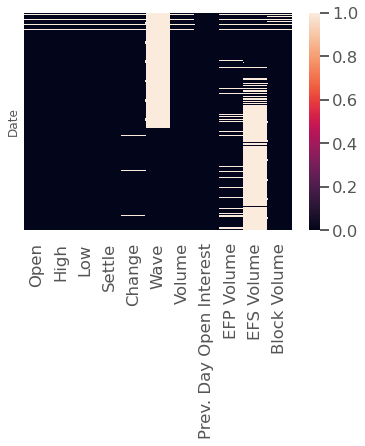

In [236]:
import seaborn as sns
%matplotlib inline
print(BC.isnull().sum())
sns.heatmap(BC.isnull(), yticklabels = False)
plt.show()

In [237]:
BC.drop(['EFP Volume','EFS Volume','Block Volume',
        'Change', 'Wave'],axis=1, inplace=True)
print(BC.columns)
print('\n')
BC= BC.fillna(method='ffill')
print(BC.isnull().sum())

Index(['Open', 'High', 'Low', 'Settle', 'Volume', 'Prev. Day Open Interest'], dtype='object')


Open                       0
High                       0
Low                        0
Settle                     0
Volume                     0
Prev. Day Open Interest    0
dtype: int64


In [238]:
BC.tail()

,Open,High,Low,Settle,Volume,Prev. Day Open Interest
Date,,,,,,
2020-12-22,50.65,50.86,49.56,50.08,192602.0,211345.0
2020-12-23,49.70,51.59,49.20,51.20,179707.0,178792.0
2020-12-24,51.11,51.77,50.62,51.29,94528.0,135884.0
2020-12-28,51.25,52.02,50.53,50.86,81059.0,128364.0
2020-12-29,51.02,51.63,50.86,51.09,87379.0,105934.0


In [239]:
BC.describe()

,Open,High,Low,Settle,Volume,Prev. Day Open Interest
count,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,76.703305,77.636198,75.713383,76.705025,212133.847780,275662.963707
std,26.827008,26.895825,26.753533,26.872973,90155.779173,142123.985821
min,19.900000,21.290000,15.980000,19.330000,9974.000000,0.000000
25%,53.777500,54.500000,52.692500,53.617500,157878.750000,173074.250000
50%,71.655000,72.725000,70.885000,71.800000,207487.500000,254343.500000
75%,106.855000,107.877500,105.850000,106.887500,266177.000000,366036.000000
max,126.580000,128.400000,125.000000,126.650000,773838.000000,676659.000000


In [240]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Ohlc(x=BC.index,
                open=BC['Open'],
                high=BC['High'],
                low=BC['Low'],
                close=BC['Settle']))

fig.update_layout(
    title='Brent Crude Futures, Continuous Contract',
    yaxis_title='Price (USD)'
)
fig.show()

In [241]:
# Calculate the daily percentage change which is daily return
data = BC["2018":].copy()

print('\033[1m' + 'Daily percentage change:' + '\033[1m')
daily_ret = data['Settle'].pct_change().dropna()
mean_return = daily_ret.mean()
return_stdev = daily_ret.std()
print('Average daily return : %1.2f%% ' % round((mean_return*100),2))
print('Average Volatility : %1.2f%% ' % round((return_stdev*100), 2))

Daily percentage change:
Average daily return : 0.01% 
Average Volatility : 3.03% 


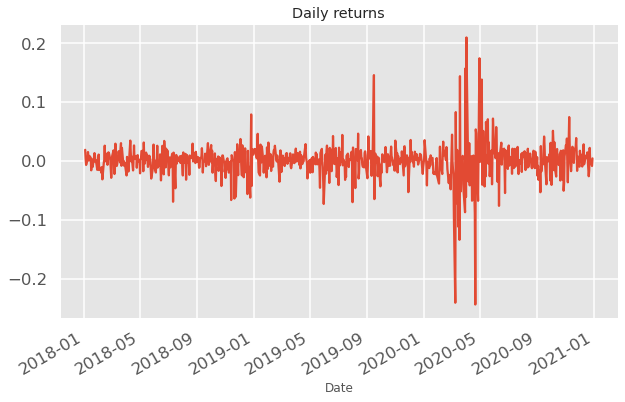

In [242]:
daily_ret.plot(figsize=(10,6),grid=True)
plt.title('Daily returns')
plt.show()

Critical Values


<IPython.core.display.Javascript object>

t test statistic:  0.11


P-value is:  0.9


Critical value at α = 0.01 with 251 df:  865.28




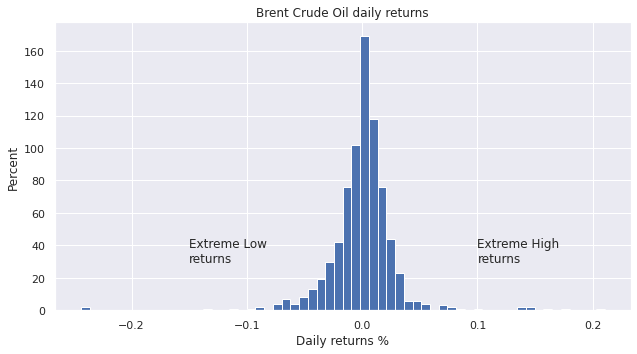



Skewness :  -0.3
Kurtosis :  18.11


In [243]:
print('\033[4mCritical Values\033[0m')
n = len(daily_ret)
test_statistic = ((daily_ret.mean() - 0) / (daily_ret.std()/np.sqrt(n)))
print ('t test statistic: ', round(test_statistic,2))
print('\n')

from scipy.stats import t
p_val = 2 * (1 - t.cdf(test_statistic, n - 1))
print ('P-value is: ', round(p_val,1))
print('\n')

from scipy.stats import chi2
# Here we calculate the critical value directly because our df is too high for most chisquare tables
crit_value = chi2.ppf(0.99, (n - 1))
print ('Critical value at α = 0.01 with 251 df: ', round(crit_value,2))
print('\n')

# Plot the distributions
fig = plt.figure(figsize=(10,5))
sns.set(rc={'figure.figsize': (15,5)})
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
daily_ret.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("Brent Crude Oil daily returns")
ax1.text(-0.15,30,"Extreme Low\nreturns")
ax1.text(0.10,30,"Extreme High\nreturns")
plt.show()
print('\n')
print("Skewness : ", round(daily_ret.skew(),2))
print("Kurtosis : ", round(daily_ret.kurtosis(),2))

In [244]:
print('\033[4mProbability of +/-(1%); +/-(3%); +/-%(5) change in price (Data -> 2018- till date)\033[0m')

print ("The probability of price changes between 1%% and -1%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.01) & (daily_ret < 0.01)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes between 3%% and -3%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.03) & (daily_ret < 0.03)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes between 5%% and -5%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.05) & (daily_ret < 0.05)].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes more than 5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret > 0.05].shape[0] / daily_ret.shape[0]))
print ("The probability of price changes less than -5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret < -0.05].shape[0] / daily_ret.shape[0]))

Probability of +/-(1%); +/-(3%); +/-%(5) change in price (Data -> 2018- till date)
The probability of price changes between 1% and -1% is 45.98% 
The probability of price changes between 3% and -3% is 85.10% 
The probability of price changes between 5% and -5% is 93.91% 
The probability of price changes more than 5% is 2.33%
The probability of price changes less than -5% is 3.76%


In [245]:
print('\033[4mMinimum price [2018- till date]\033[0m')
print(round(data['Settle'].min(),2), data['Settle'].idxmin());
print('\033[4mMaximum price [2018- till date]\033[0m')
print(round(data['Settle'].max(),2), data['Settle'].idxmax());
print('\n')

print('\033[4mMinimum daily % return [2018- till date]\033[0m')
print(round(daily_ret.min(),2)*100, daily_ret.idxmin()); 
print('\033[4mMaximum daily % return [2018- till date]\033[0m')
print(round(daily_ret.max()*100, 2), daily_ret.idxmax());

Minimum price [2018- till date]
19.33 2020-04-21 00:00:00
Maximum price [2018- till date]
86.29 2018-10-03 00:00:00


Minimum daily % return [2018- till date]
-24.0 2020-04-21 00:00:00
Maximum daily % return [2018- till date]
21.02 2020-04-02 00:00:00


In [246]:
# Get the number of days
days = (data.index[-1] - data.index[0]).days

# Calculate the CAGR 
cagr = ((((data['Settle'][-1]) / data['Settle'][1])) ** (252.0/days)) - 1

# Print the CAGR
print('CAGR:',round(cagr*100))

CAGR: -6.0


In [247]:
perf = BC['Settle'].calc_stats()
print('\n')
perf.display()



Stats for Settle from 2010-01-04 00:00:00 - 2020-12-29 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-36.23%             0.07  -4.01%  -84.74%

Annualized Returns:
mtd    3m      6m      ytd      1y       3y      5y     10y     incep.
-----  ------  ------  -------  -------  ------  -----  ------  --------
6.70%  24.52%  22.49%  -22.59%  -25.04%  -8.58%  6.21%  -5.93%  -4.01%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.07     0.09       -0.05
mean    2.51%    3.14%      -1.61%
vol     35.97%   34.35%     30.15%
skew    -0.06    -0.25      0.15
kurt    17.65    5.56       -0.29
best    21.02%   42.90%     52.41%
worst   -24.40%  -46.95%    -48.26%

Drawdowns:
max      avg       # days
-------  ------  --------
-84.74%  -8.24%    207.32

Misc:
---------------  ------
avg. up month    6.35%
avg. down month  -7.89%
up year %        5

In [248]:
perf.stats

start                    2010-01-04 00:00:00
end                      2020-12-29 00:00:00
rf                                         0
total_return                       -0.362332
cagr                              -0.0401344
max_drawdown                       -0.847375
calmar                            -0.0473632
mtd                                0.0670426
three_month                         0.245186
six_month                           0.224886
ytd                                -0.225909
one_year                            -0.25044
three_year                        -0.0857947
five_year                          0.0621383
ten_year                          -0.0592812
incep                             -0.0401344
daily_sharpe                       0.0698055
daily_sortino                       0.111358
daily_mean                         0.0251063
daily_vol                           0.359661
daily_skew                        -0.0641624
daily_kurt                           17.6527
best_day  

In [249]:
qq = pd.DataFrame(index = BC.index)
qq['h_o'] = (BC['High'].pct_change() - BC['Open'].pct_change()) # distance between Highest and Opening price
qq['l_o'] = (BC['Low'].pct_change() - BC['Open'].pct_change()) # distance between Lowest and Opening price
qq['gain'] = (BC['Settle'].pct_change() - BC['Open'].pct_change())
qq['price_diff'] = BC['Settle'].diff()
qq['close'] = BC['Settle']


lags = 3
# Create the shifted lag series of prior trading period close values
for i in range(0, lags):
    qq["Lag%s" % str(i+1)] = BC["Settle"].shift(i+1).pct_change()
    
qq['HL'] = (BC['High'] - BC['Settle']) / BC['Settle'] 
# creating more features
qq['norm_returns'] = BC['Settle'].pct_change()
qq['vol_increment'] = BC.Volume.diff() / BC.Volume
qq['pdoi'] = BC['Prev. Day Open Interest'].pct_change()
qq = qq.dropna()
qq.head()

<IPython.core.display.Javascript object>

,h_o,l_o,gain,price_diff,close,Lag1,Lag2,Lag3,HL,norm_returns,vol_increment,pdoi
Date,,,,,,,,,,,,
2010-01-08,0.005976,0.000300,0.004258,-0.14,81.37,-0.004640,0.016131,0.005866,0.008357,-0.001718,0.145914,-0.114403
2010-01-11,0.004630,-0.002479,-0.005161,-0.40,80.97,-0.001718,-0.004640,0.016131,0.018278,-0.004916,-0.166774,-0.138315
2010-01-12,-0.007264,-0.011858,-0.008605,-1.67,79.30,-0.004916,-0.001718,-0.004640,0.019672,-0.020625,0.068156,-0.194363
2010-01-13,0.003684,0.007100,0.013090,-0.99,78.31,-0.020625,-0.004916,-0.001718,0.009960,-0.012484,-0.338782,-0.376668
2010-01-14,-0.002155,0.005077,-0.007022,-0.49,77.82,-0.012484,-0.020625,-0.004916,0.014906,-0.006257,-3.851248,-0.514453


In [250]:
print(qq.shape)

(2834, 12)


In [251]:
# positive value = 1, otherwise, 0
qq.loc[:,"target"] = np.where(qq['price_diff']> 0, 1.0, 0.0)
qq.drop(['price_diff'],1, inplace=True)
qq.head()

<IPython.core.display.Javascript object>

,h_o,l_o,gain,close,Lag1,Lag2,Lag3,HL,norm_returns,vol_increment,pdoi,target
Date,,,,,,,,,,,,
2010-01-08,0.005976,0.000300,0.004258,81.37,-0.004640,0.016131,0.005866,0.008357,-0.001718,0.145914,-0.114403,0.0
2010-01-11,0.004630,-0.002479,-0.005161,80.97,-0.001718,-0.004640,0.016131,0.018278,-0.004916,-0.166774,-0.138315,0.0
2010-01-12,-0.007264,-0.011858,-0.008605,79.30,-0.004916,-0.001718,-0.004640,0.019672,-0.020625,0.068156,-0.194363,0.0
2010-01-13,0.003684,0.007100,0.013090,78.31,-0.020625,-0.004916,-0.001718,0.009960,-0.012484,-0.338782,-0.376668,0.0
2010-01-14,-0.002155,0.005077,-0.007022,77.82,-0.012484,-0.020625,-0.004916,0.014906,-0.006257,-3.851248,-0.514453,0.0


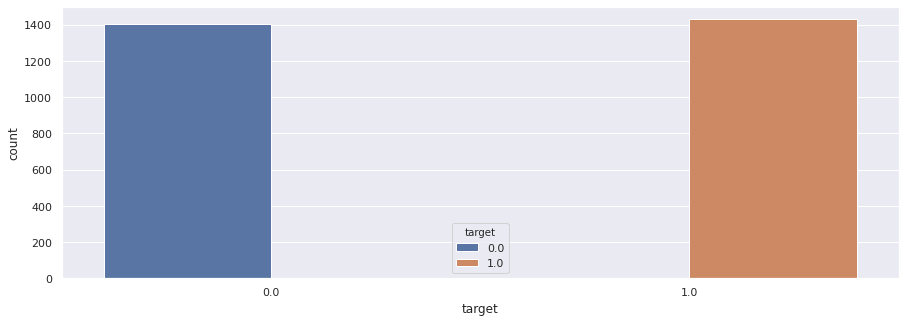

In [252]:
import seaborn as sns
sns.countplot(x = 'target', data=qq, hue='target')
plt.show()

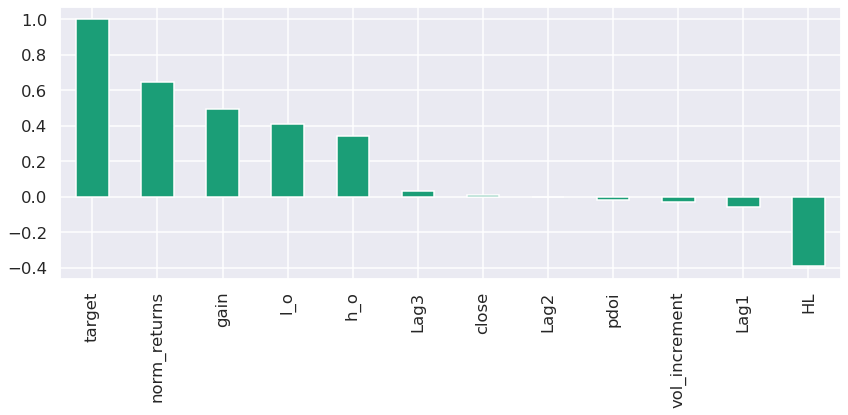

In [253]:
# Checking Correlation 
sns.set(style='darkgrid', context='talk', palette='Dark2')
plt.figure(figsize=(14,5))
qq.corr()['target'].sort_values(ascending = False).plot(kind='bar')
plt.show()

In [254]:
import matplotlib
matplotlib.use('Agg')

X = qq.drop(columns= ['target', 'Lag1', 'Lag2', 'Lag3', 'pdoi', 
             'close','vol_increment'], axis=1)
y = qq.target.astype(np.integer)

<IPython.core.display.Javascript object>

In [255]:
pip install tscv

Note: you may need to restart the kernel to use updated packages.


In [256]:
"""
predictor is set to use only the first two lags. so, 
implicitly stating to the classifier that the further lags are of less predictive value
"""
    
# # Create training and test sets
from tscv import GapKFold
gkcv = GapKFold(n_splits=5, gap_before=2, gap_after=1)

"""
Introduced gaps between the training and test set to mitigate the temporal dependence.
Here the split function splits the data into Kfolds. 
The test sets are untouched, while the training sets get the gaps removed
"""

for tr_index, te_index in gkcv.split(X, y):
    xTrain, xTest = X.values[tr_index], X.values[te_index];
    yTrain, yTest = y.values[tr_index], y.values[te_index];
        
print('Observations: %d' % (len(xTrain) + len(xTest)))
print('Training Observations: %d' % (len(xTrain)))
print('Testing Observations: %d' % (len(xTest)))

Observations: 2832
Training Observations: 2266
Testing Observations: 566


In [257]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

In [ ]:
xgb = XGBClassifier()
logreg2 = LogisticRegression(solver='lbfgs')
knn = KNeighborsClassifier(5)
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lsvc = LinearSVC()
rsvm = SVC(C=1000000.0, cache_size=200, class_weight=None,
                       coef0=0.0, degree=3, gamma=0.0001, kernel='rbf',
                       max_iter=-1, probability=False, random_state=None,
                       shrinking=True, tol=0.001, verbose=False)
rfc = RandomForestClassifier(
              n_estimators=1000, criterion='gini',
              max_depth=None, min_samples_split=2,
              min_samples_leaf=1, max_features='auto',
              bootstrap=True, oob_score=False, n_jobs=1,
              random_state=None, verbose=0)

# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('XGB', XGBClassifier()))
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('RF', RandomForestClassifier(
              n_estimators=1000, criterion='gini',
              max_depth=None, min_samples_split=2,
              min_samples_leaf=1, max_features='auto',
              bootstrap=True, oob_score=False, n_jobs=1,
              random_state=None, verbose=0)))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('LSVC', LinearSVC()))
models.append(('RSVM', SVC(C=1000000.0, cache_size=200, class_weight=None,
                       coef0=0.0, degree=3, gamma=0.0001, kernel='rbf',
                       max_iter=-1, probability=False, random_state=None,
                       shrinking=True, tol=0.001, verbose=False)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    #kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, xTrain, yTrain, cv=gkcv, 
                                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

XGB: 1.000000 (0.000000)
LR: 0.836291 (0.025296)
KNN: 0.952346 (0.012957)
LDA: 0.974858 (0.016397)


In [ ]:
from sklearn.decomposition import PCA
whiten = False
random_state = 2020

pca_2c = PCA(n_components=2, whiten = whiten, random_state = random_state)
x_pca_2c = pca_2c.fit_transform(xTrain)
print(x_pca_2c.shape)
print(pca_2c.explained_variance_ratio_.sum()); print()

In [ ]:
from mlxtend.plotting import plot_decision_regions
lda = LinearDiscriminantAnalysis().fit(x_pca_2c,yTrain)
yhat = lda.predict(x_pca_2c)

# plot decision region to visualize
plot_decision_regions(x_pca_2c, yTrain, clf=lda, legend=2)
# axes annotations
plt.xlabel('comp_1'); plt.ylabel('comp_2')
plt.title('Decision boundary')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('\n Classification Report:\n', classification_report(yTrain, yhat))

In [ ]:
m = LinearDiscriminantAnalysis().fit(X,y)
#yhat = m.predict(X)
qq.loc[:,'Predicted_Signal'] = m.predict(X)
qq = qq[['close', 'norm_returns', 'target', 'Predicted_Signal']]

"""
we will limit the number of orders by restricting ourselves to the number of positions on the market. 
we will apply diff() to the column signal:
"""
qq.loc[:,'Strategy'] = qq.loc[:,'Predicted_Signal'].diff()
qq

- 0= buy
- 1 = sell

In [ ]:
print('Number of trades (buy) = ', (qq.Strategy!=0).sum())
print('Number of trades (sell) = ', (qq.Strategy!=1).sum())

In [ ]:
# collect last 100 postions for visualization
dd = qq[-100:]
dd

In [ ]:
# visualize last 100 positions
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111, ylabel='Brent Crude Oil price in $')
dd["close"][-100:].plot(ax=ax1, color='b', lw=.5)
ax1.plot(dd.loc[dd.Strategy ==1.0].index[-100:], dd.close[dd.Strategy == 1.0][-100:],
         '^', markersize=7, color='green')
ax1.plot(dd.loc[dd.Strategy ==-1.0].index[-100:], dd.close[dd.Strategy == -1.0][-100:],
         'v', markersize=7, color='red')
plt.show()

In [ ]:
BC.tail(2)

In [ ]:
dq = BC.tail(620)
lows = BC['Low']
highs = BC['High']

fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Crude Oil price in $')
highs.plot(ax=ax1, color='c', lw=2.)
lows.plot(ax=ax1, color='y', lw=2.)
plt.hlines(highs.head(200).max(),lows.index.values[0],
           lows.index.values[-1],linewidth=2, color='g')
plt.hlines(lows.head(200).min(),lows.index.values[0],
           lows.index.values[-1], linewidth=2, color='r')
plt.axvline(linewidth=2,color='b',x=lows.index.values[200],linestyle=':')
plt.show()

In [ ]:
de = qq.copy()
def Support_Resistance_Trading(data, bin_width=20):
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data)))
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support=0
    in_resistance=0
    
    for x in range((bin_width - 1) + bin_width, len(data)):
        data_section = data[x - bin_width:x + 1]
        support_level=min(data_section['close'])
        resistance_level=max(data_section['close'])
        range_level=resistance_level-support_level
        data['res'][x]=resistance_level
        data['sup'][x]=support_level
        data['sup_tolerance'][x]=support_level + 0.2 * range_level
        data['res_tolerance'][x]=resistance_level - 0.2 * range_level

        if data['close'][x]>=data['res_tolerance'][x] and data['close'][x] <= data['res'][x]: 
            in_resistance+=1
            data['res_count'][x]=in_resistance
        elif data['close'][x] <= data['sup_tolerance'][x] and data['close'][x] >= data['sup'][x]:
            in_support += 1
            data['sup_count'][x] = in_support
        else:
            in_support=0
            in_resistance=0
        if in_resistance>2:
            data['signal'][x]=1
        elif in_support>2:
            data['signal'][x]=0
        else:
            data['signal'][x] = data['signal'][x-1]
    
    data.loc[:,'positions'] = data.loc[:,'signal'].diff()

Support_Resistance_Trading(de)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Crude Oil price in $')
de['sup'].plot(ax=ax1, color='green', lw=2.)
de['res'].plot(ax=ax1, color='b', lw=2.)
de['close'].plot(ax=ax1, color='gray', lw=2.)
ax1.plot(de.loc[de.positions == 1.0].index,
         de.close[de.positions == 1.0],
         '^', markersize=7, color='k',label='buy')
ax1.plot(de.loc[de.positions == -1.0].index,
         de.close[de.positions == -1.0],
         'v', markersize=7, color='red',label='sell')
plt.legend()
plt.show()

In [ ]:
qq['cum_returns'] = 100*qq['norm_returns'].cumsum()
qq['cum_strategy_returns']= 100*(qq['norm_returns'] * qq['Strategy'].shift(1)).cumsum()
qq

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(qq['cum_returns'], label = 'Crude Oil returns')
plt.plot(qq['cum_strategy_returns'], label = 'Strategy returns')
plt.legend(loc='best')
plt.show()

In [ ]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()
print(sharpe_ratio(qq.cum_strategy_returns, qq.cum_returns))

In [ ]:
#strategy_std = qq.cum_strategy_returns.std().np.sqrt(252)
# print('Sharpe Ratio:',qq.cum_returns.mean() / qq.cum_returns.std())

In [ ]:
qq = qq.reset_index()
qq.tail()

In [ ]:
class Portfolio:
    def __init__(self):
        self.lot_size_long = 1
        self.lot_size_short = 1
        self.contract_size = 1
        self.initial_cash = 10000
        self.buy = (np.where(qq.Strategy == 1, 
                                        self.lot_size_long * self.contract_size *qq.close, 0))
        self.sell = (np.where(qq.Strategy == (-1), 
                                        self.lot_size_short * self.contract_size *qq.close, 0))
        
    def long_amt(self):
        self.buy = (np.where(qq.Strategy == 1,
                                     Portfolio().lot_size_long * 
                                       Portfolio().contract_size *qq.close, 0))
        return self.buy
        
    def cash_delta(self):
        self.cash_delta = Portfolio().buy + Portfolio().sell
        return self.cash_delta
    
    def end_bal(self):
        self.end_bal = Portfolio().initial_cash + Portfolio().cash_delta().cumsum()
        return self.end_bal
    
    def end_pos(self):
        self.end_pos = qq.Strategy.cumsum()
        return self.end_pos
        
p = Portfolio()
qq['Buy'] = p.buy
qq['Sell'] = p.sell
qq['CashDelta'] = p.cash_delta()
qq['EndBalance'] = p.end_bal()
qq['EndPosition'] = p.end_pos()
qq.loc[:, ['Date', 'close', 'Strategy','Buy', 'Sell', 
                 'CashDelta', 'EndBalance', 'EndPosition']]

In [ ]:
qq['pnl'] = qq['EndBalance'] + (qq.EndPosition * qq.close * Portfolio().contract_size)
qq.loc[:, ['Date', 'close', 'EndBalance', 'EndPosition', 'pnl']]

In [ ]:
d = qq.set_index('Date')
plt.figure(figsize=(15,5))
plt.plot(d.pnl)